# n3gb - The NUAR hex-based spatial indexing system

The n3gb indexing system was inspired by the [h3 spatial index](https://h3geo.org) originally developed by Uber and now open sourced. The NUAR project is working on a Generalised Data API to enable statisitics and information about buried asset data without the need to divulge the exact details and locations of said assets. While H3 provides the ideal structure for aggregating this data its global nature means that it is based on WGS84 and therefore not ideal for use in a NUAR context. Whilst we havbe created endpoints in our API to make use of H3 we decided to create our own variant that is built for the British National Grid. 

In devising our approach to a spatial indexing system we based it on the following principles:

- All hex cells must have a unque identifier
- The unique identifier must be stable and consistent
- The hex cell must be algorithmically generated
- The hex cell must be different sizes at different zoom levels, with the size appropriate for analysis at that zoom level
- The hex cell areas should be approximately similar to the H3 grid
- It should be possible to determine the next child(s) hexagon from a given hexagon
- It should be possible to determine the parent hexagon from a given hxagon

This notebook provides an interactive appraisal of the algorithms used to generate and identify hex cells using the n3gb system.

In [1]:
import math
import base64
import struct
from shapely import Polygon

Create the functions that can be used to calculate and generate hex grids.

In [2]:
# Set some constants that define the grid extent and the widths of hexagons at each zoom level
IDENTIFIER_VERSION = 1
SCALE_FACTOR = 1000  # To preserve three decimal places
GRID_EXTENTS = [0, 0, 750000, 1350000]
CELL_RADIUS = [1281249.9438829257,483045.8762201923, 182509.65769514776, 68979.50076169973, 26069.67405498836, 9849.595592375015, 3719.867784388759, 1399.497052515653, 529.4301968468868, 199.76319313961054, 75.05553499465135, 28.290163190291665, 10.392304845413264, 4.041451884327381, 1.7320508075688774, 0.5773502691896258]
CELL_WIDTHS = [2219190, 836660, 316116, 119476, 45154, 17060, 6443, 2424, 917, 346, 130, 49, 18, 7, 3, 1]

def generate_identifier(easting, northing, zoom_level):
    # Multiply easting and northing to preserve 2 decimal places and convert to int
    easting_int = round(easting * SCALE_FACTOR)
    northing_int = round(northing * SCALE_FACTOR)
    
    # Pack the data into a binary representation (each as 8 bytes = 64 bits for compatibility and future-proofing)
    binary_data = struct.pack(">BQQB", IDENTIFIER_VERSION, easting_int, northing_int, zoom_level)
    # Explanation:
    # > : big-endian byte order
    # B : unsigned char (1 byte) for version
    # Q : unsigned long long (8 bytes) for easting
    # Q : unsigned long long (8 bytes) for northing
    # B : unsigned char (1 byte) for zoom level

    checksum = (sum(binary_data) & 0xFF).to_bytes(1, byteorder='big')

    # Encode to URL-safe Base64 and remove any padding for compactness
    base64_encoded = base64.urlsafe_b64encode(binary_data + checksum).rstrip(b"=")

    return base64_encoded.decode("ascii")

def decode_hex_identifier(identifier):
    # Decode the identifier from URL-safe Base64, adding padding if necessary
    b = base64.urlsafe_b64decode(identifier + "=" * (-len(identifier) % 4)) 
    
    # Validate length
    if len(b) != 19: 
        raise ValueError("The identifier length is invalid.") 
    
    # Separate binary data and checksum
    binary_data, checksum = b[:-1], b[-1] 

    # Validate checksum
    if (sum(binary_data) & 0xFF) != checksum: 
        raise ValueError("The identifer checksum is invalid, potentially corrupted data.") 
    
    # Unpack the binary data
    version, easting_int, northing_int, zoom = struct.unpack(">BQQB", binary_data) 
    
    # Validate version
    if version != IDENTIFIER_VERSION: 
        raise ValueError(f"Unsupported identifier version. Expected [{IDENTIFIER_VERSION}] but got [{version}]") 
    
    # Convert back to float by dividing by SCALE_FACTOR
    return version, easting_int / SCALE_FACTOR, northing_int / SCALE_FACTOR, zoom

def create_hexagon(center_x, center_y, size):
    """
    Create a hexagon polygon centered at (center_x, center_y) with the given size.

    Args:
        center_x (float): X coordinate of the center.
        center_y (float): Y coordinate of the center.
        size (float): Size of the hexagon.

    Returns:
        shapely.geometry.Polygon: Hexagon polygon.
    """
    points = [
        (
            center_x + size * math.cos(math.radians(angle)),
            center_y + size * math.sin(math.radians(angle))
        )
        for angle in range(30, 390, 60)
    ]
    return Polygon(points)
    
def point_to_hex(x, y, z):
    """
    Convert a point (x, y) to the corresponding hexagon index in a grid.

    Args:
        x (float): X coordinate of the point.
        y (float): Y coordinate of the point.
        z (int): Zoom level.

    Returns:
        tuple: Row and column indices of the hexagon containing the point.
    """
    hex_width = CELL_WIDTHS[z]  # Width of the hexagon at the given zoom level
    r = CELL_RADIUS[z]  # Radius of the hexagon at the given zoom level
    dx = hex_width  # Horizontal distance between hexagon centers
    dy = 1.5 * r  # Vertical distance between hexagon centers
    
    qx = (x - GRID_EXTENTS[0]) / dx
    ry = (y - GRID_EXTENTS[1]) / dy
    
    row = int(round(ry))
    col = int(round(qx - (row % 2)))  # Adjust for odd/even rows
    
    return row, col

def hex_to_point(row, col, z):
    """
    Convert hexagon indices (row, col) to the corresponding point (x, y).

    Args:
        row (int): Row index of the hexagon.
        col (int): Column index of the hexagon.
        z (int): Zoom level.

    Returns:
        tuple: X and Y coordinates of the center of the hexagon.
    """
    hex_width = CELL_WIDTHS[z]  # Width of the hexagon at the given zoom level
    r = CELL_RADIUS[z]  # Radius of the hexagon at the given zoom level
    dx = hex_width  # Horizontal distance between hexagon centers
    dy = 1.5 * r  # Vertical distance between hexagon centers
    
    x = GRID_EXTENTS[0] + col * dx + ((row % 2) * (dx / 2))
    y = GRID_EXTENTS[1] + row * dy
    
    return x, y

def get_hexes_for_extent(extents, zoom_level):
    """
    Returns all hexagons that intersect the given extents at the zoom level specified.

    Args:
        extents (list): The extents to intersect, expressed as [minx, miny, maxx, maxy]
        zoom_level (int): The zoom level to calculate intersections at

    Returns:
        list: A list of hexagons that intersect the extents at the zoom level
    """

    # Get the grid references at each corner of the extent
    ll_row, ll_col = point_to_hex(extents[0], extents[1], zoom_level)
    lr_row, lr_col = point_to_hex(extents[2], extents[1], zoom_level)
    ur_row, ur_col = point_to_hex(extents[2], extents[3], zoom_level)
    ul_row, ul_col = point_to_hex(extents[0], extents[3], zoom_level)

    # Get the minimum and maximum row and column values
    max_row = max(ll_row, lr_row, ur_row, ul_row)
    max_col = max(ll_col, lr_col, ur_col, ul_col)
    min_row = min(ll_row, lr_row, ur_row, ul_row)
    min_col = min(ll_col, lr_col, ur_col, ul_col)

    # Create an empty list for the hexagons to be populated
    hexagons = []

    # Loop over the calculated rows and columns to determine all hexagons
    for row in range(min_row, max_row + 1):
        for col in range(min_col, max_col + 1):
            # Get the x and y centroid of the hexagon
            x, y = hex_to_point(row, col, zoom_level)

            # Only act on hexagons that are within the grid extents
            #if x < GRID_EXTENTS[0] or x > GRID_EXTENTS[2] or y < GRID_EXTENTS[1] or y > GRID_EXTENTS[3]:
            #    continue
            if x < GRID_EXTENTS[0] or y < GRID_EXTENTS[1]:
                continue

            # Create the hexagon geometry
            hexagon = create_hexagon(x, y, CELL_RADIUS[zoom_level])

            # Define the attributes for the hexagon
            hexagons.append({
                "id": generate_identifier(x, y, zoom_level),
                "easting": x,
                "northing": y,
                "zoom_level": zoom_level,
                "row": row,
                "col": col,
                "geom": hexagon
            })

    # Return the intersected hexagons
    return hexagons

## Generating and using Hex Cells

We can use the functions above to calculate and generate hex grid cells, for example:

- Provide easting, northing, zoom level and get the intersecting hex grid cell
- Provide a bounding box and zoom level and return all hex grid cells that intersect the bounds
- Provide a hex grid cell identifier and have it decoded
- Create a hexagon given the centre point (easting, northing) and the zoom level

### Encoding and decoding hex grid identifiers

This example shows how coordinates (easting and northing) and a zoom level can be encoded to the unique identifier used by the grid system. Then how that identifier can be decoded in order to get the corresponding easting, northing, and zoom level.

In [3]:
# Encode easting, northing, and zoom level to a hex grid cell
identifier = generate_identifier(252086.1234, 847702.1234, 10)
print(f"Generated hex identifier: {identifier}")

# Decode the identifier back to easting, northing, and zoom level
version, easting, northing, zoom_level = decode_hex_identifier(identifier)
print(f"Decoded hex identifier: V{version} E{easting} N{northing} Z{zoom_level}")

Generated hex identifier: AQAAAAAPBodrAAAAADKG6GsKHQ
Decoded hex identifier: V1 E252086.123 N847702.123 Z10


### Generate the Hex Cells that intersect a bounding box

This example shows how a bounding box extent (minx, miny, maxx, maxy) can be used to generate all hex grid cells that intersect the bounding box at a given zoom level. The bounding box is a sample area of data in Nottingham.

In [4]:
import geopandas as gpd

# Get hexagons that intersect the given bounding box at zoom level 10
hexagons = get_hexes_for_extent([457000, 339500, 458000, 340500], 12)

# Convert the hexagons to a geo data frame
gdf_hexagons = gpd.GeoDataFrame(hexagons, geometry='geom', crs='EPSG:27700')
gdf_hexagons['easting'] = gdf_hexagons['easting'].map(lambda x: f"{x:.3f}")  # Format easting to 3 decimal places
gdf_hexagons['northing'] = gdf_hexagons['northing'].map(lambda x: f"{x:.3f}")  # Format northing to 3 decimal places

# Show the geo dataframe table
gdf_hexagons

,id,easting,northing,zoom_level,row,col,geom
0,AQAAAAAbPSjoAAAAABQ8X9MM9w,456993.000,339501.011,12,21779,25388,"POLYGON ((457002 339506.207, 456993 339511.403..."
1,AQAAAAAbPW84AAAAABQ8X9MMjg,457011.000,339501.011,12,21779,25389,"POLYGON ((457020 339506.207, 457011 339511.403..."
2,AQAAAAAbPbWIAAAAABQ8X9MMJA,457029.000,339501.011,12,21779,25390,"POLYGON ((457038 339506.207, 457029 339511.403..."
3,AQAAAAAbPfvYAAAAABQ8X9MMug,457047.000,339501.011,12,21779,25391,"POLYGON ((457056 339506.207, 457047 339511.403..."
4,AQAAAAAbPkIoAAAAABQ8X9MMUg,457065.000,339501.011,12,21779,25392,"POLYGON ((457074 339506.207, 457065 339511.403..."
...,...,...,...,...,...,...,...
3635,AQAAAAAbSyrYAAAAABRLmPAMXA,457911.000,340498.672,12,21843,25439,"POLYGON ((457920 340503.868, 457911 340509.064..."
3636,AQAAAAAbS3EoAAAAABRLmPAM8w,457929.000,340498.672,12,21843,25440,"POLYGON ((457938 340503.868, 457929 340509.064..."
3637,AQAAAAAbS7d4AAAAABRLmPAMiQ,457947.000,340498.672,12,21843,25441,"POLYGON ((457956 340503.868, 457947 340509.064..."
3638,AQAAAAAbS_3IAAAAABRLmPAMHw,457965.000,340498.672,12,21843,25442,"POLYGON ((457974 340503.868, 457965 340509.064..."


### Identify Hex Grid Cell a point intersects

This example shows how the grid algorithms can be used to find what hex grid cell a given point location is within, this can be useful for example to identify what hex grid cell a point feature is within. These could then be aggregated up to provide a feature count per hex grid cell.

First we'll simply provide a point location and then find the identifier of the hex grid cell at zoom level 8 the point falls within.

In [5]:
# Set the easting, northing, and zoom level
easting = 457996
northing = 339874
zoom_level = 10

# Find what hex grid cell the point intersects at the zoom level
hex_row, hex_col = point_to_hex(easting, northing, zoom_level)

# Now we have the cell row and column we can get the centre point of the hexagon
hex_cell_x, hex_cell_y = hex_to_point(hex_row, hex_col, zoom_level)

# We can now use the hexagon's centre point to create a hexagon geometry
hexagon = create_hexagon(hex_cell_x, hex_cell_y, CELL_RADIUS[zoom_level])

print(f"The point [{easting}, {northing}] at zoom level [{zoom_level}] is within hex grid cell [{hex_row}, {hex_col}]")
print("***")
print(f"The hex grid cell [{hex_row}, {hex_col}] has a centre point of [{hex_cell_x}, {hex_cell_y}] at zoom level [{zoom_level}]")
print("***")
print(f"The hexagon geometry for the cell [{hex_row}, {hex_col}] is: {hexagon.wkt}")

The point [457996, 339874] at zoom level [10] is within hex grid cell [3019, 3522]
***
The hex grid cell [3019, 3522] has a centre point of [457925.0, 339888.9902232787] at zoom level [10]
***
The hexagon geometry for the cell [3019, 3522] is: POLYGON ((457990 339926.51799077605, 457925 339964.04575827334, 457860 339926.51799077605, 457860 339851.46245578135, 457925 339813.93468828406, 457990 339851.46245578135, 457990 339926.51799077605))


### Putting it all on a map

A picture paints a thousand words, or in this case makes it prettier to look at than a table!

We are going to take the hexagons calculated with our bounding box and plot them to a map with an OS Basemap and the hex grid overlayed. The hex cells will be red outlined with a semi-transparent red fill and we shall include the bounding box we used to generate the hex cells as a blue polygon.

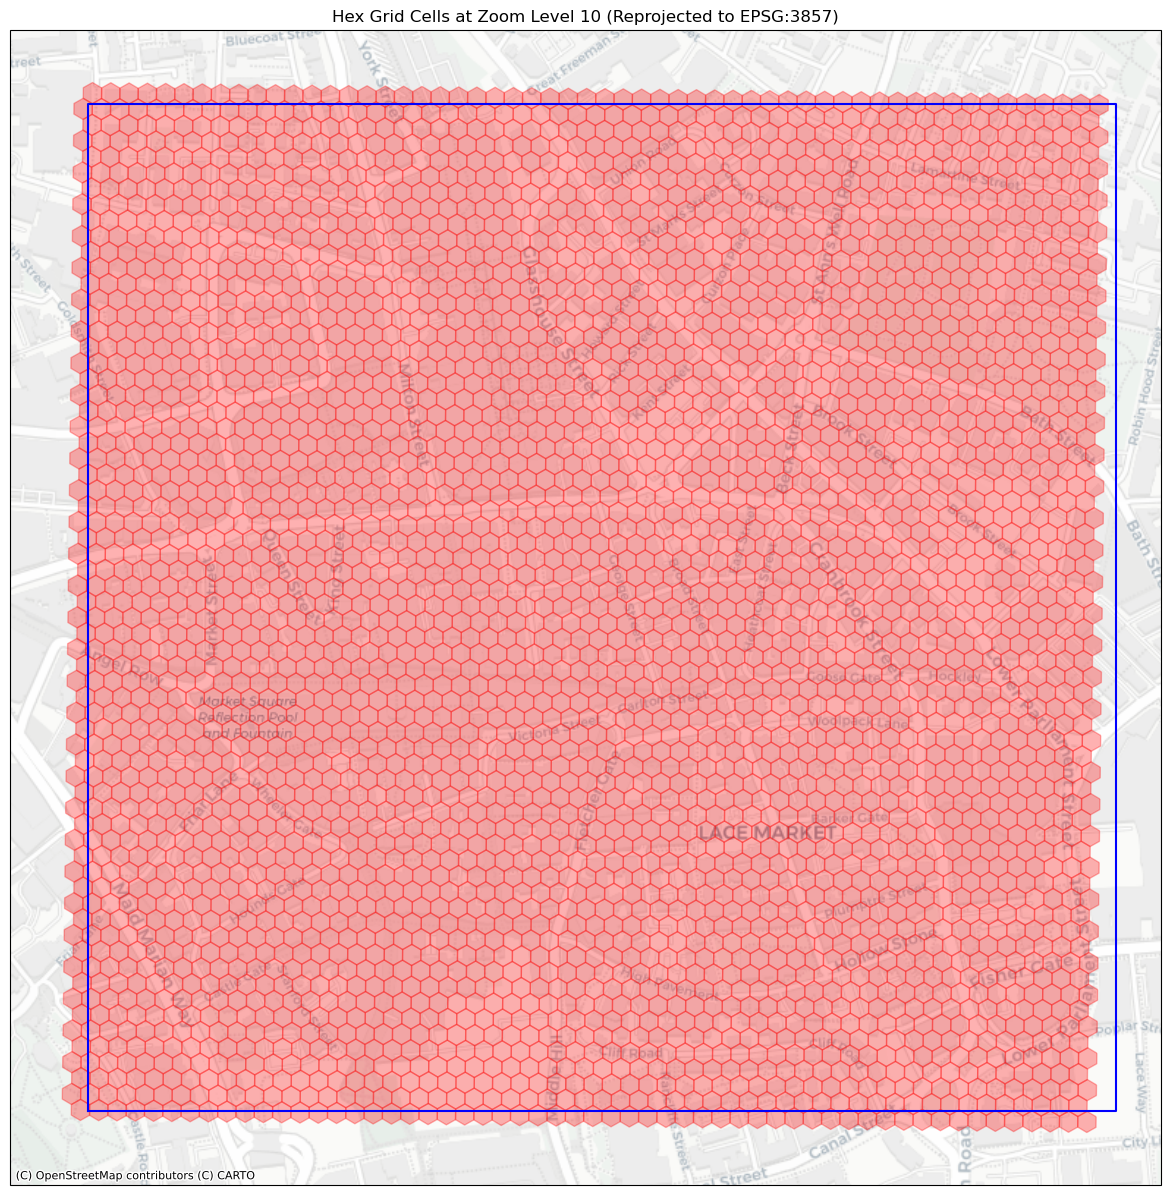

In [6]:
import contextily as ctx
import xyzservices.providers as xyz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyproj import Transformer

# Plot the GeoDataFrame with a basemap, we need to transform the GeoDataFrame to EPSG:3857 for the basemap
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={'projection': ccrs.Mercator()})
hexagons_3857 = gdf_hexagons.to_crs(epsg=3857)
hexagons_3857.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.3)
ctx.add_basemap(ax, crs="EPSG:3857", source=xyz.CartoDB.Positron)

# Add the bounding box of the area of interest to the plot
minx, miny, maxx, maxy = 457000, 339500, 458000, 340500
transformer = Transformer.from_crs("EPSG:27700", "EPSG:3857", always_xy=True)
bbox_minx, bbox_miny = transformer.transform(minx, miny)
bbox_maxx, bbox_maxy = transformer.transform(maxx, maxy)
plt.plot(
    [bbox_minx, bbox_maxx, bbox_maxx, bbox_minx, bbox_minx],
    [bbox_miny, bbox_miny, bbox_maxy, bbox_maxy, bbox_miny],
    'b-'
)

# Show the plot
plt.title("Hex Grid Cells at Zoom Level 10 (Reprojected to EPSG:3857)")
plt.show()

### Exporting to a GeoParuet file

Of course it is great to be able to algorithmically generate these hex cells, but sometimes you'll want to be able to write them out to a file to share with others. There are many GIS formats that could be used for this task, but given the data analytics/science based usage for this kind if indexing system we are going to export the cells above to a GeoParquet file.

In [7]:
# Write gdf_hexagons to a Geoparquet file
gdf_hexagons.to_parquet("C:\\Temp\\hexagons.parquet", index=False)

## Calculating the Dimensions

It is possible to calculate the different dimensions of a hexagon when given another dimension. This can be useful to provide details of the dimensions of the hexagon when sharing the grid, for example a service generating hex grids could provide dimension attributes for each cell in the grid, or it can be useful to be able to explain in your analyses what the dimensions of a cell are.

We can create a Python class to hold the dimensions and some functions that can be used to calculate dimensions when given others. The dimensions of a hexagon are:

| Dimension | Description                       |
|-----------|-----------------------------------|
|a          | Length of each side               |
|R          | Circumradius (centre to a vertex) |
|r          | Apothem (centre to edge)          |
|Dc         | Across corners (point to point)   |
|Df         | Across flats (flat-to-flat)       |
|P          | Perimeter                         |
|A          | Area                              |

The dimensions `Dc` and `Df` can also be considered as the width and height of the hexagon, but which is which depends on the orientation of the polygon. In n3gb the orientation of hexagons is "pointy-top" which means the points of the hexagon are top and bottom rather than left and right. Therefore, in our orientation `Dc` is height and `Df` is width.

In [8]:
from __future__ import annotations
from dataclasses import dataclass
from math import sqrt
from typing import Literal, Dict


@dataclass(frozen=True)
class HexagonDims:
    """All key dimensions of a regular hexagon (orientation-invariant).
    a  : side length
    R  : circumradius (centre to vertex)
    r  : apothem (centre to side)
    Dc : across corners (point-to-point)
    Df : across flats (flat-to-flat)
    P  : perimeter
    A  : area
    """
    a: float
    R: float
    r: float
    Dc: float
    Df: float
    P: float
    A: float

    def as_dict(self) -> Dict[str, float]:
        return {
            "a": self.a, "R": self.R, "r": self.r,
            "Dc": self.Dc, "Df": self.Df, "P": self.P, "A": self.A
        }

SQRT3 = sqrt(3.0)

def _from_side(a: float) -> HexagonDims:
    if a <= 0:
        raise ValueError("Side length a must be positive.")
    R = a
    r = (SQRT3 / 2.0) * a
    Dc = 2.0 * a
    Df = SQRT3 * a
    P = 6.0 * a
    A = (3.0 * SQRT3 / 2.0) * a * a
    return HexagonDims(a=a, R=R, r=r, Dc=Dc, Df=Df, P=P, A=A)


def from_side(a: float) -> HexagonDims:
    """Compute all hexagon dimensions from side length a."""
    return _from_side(a)


def from_circumradius(R: float) -> HexagonDims:
    """Compute all hexagon dimensions from circumradius R (for a regular hexagon, R = a)."""
    return _from_side(R)


def from_apothem(r: float) -> HexagonDims:
    """Compute all hexagon dimensions from apothem r."""
    if r <= 0:
        raise ValueError("Apothem r must be positive.")
    a = 2.0 * r / SQRT3
    return _from_side(a)


def from_across_flats(Df: float) -> HexagonDims:
    """Compute all hexagon dimensions from across-flats distance Df."""
    if Df <= 0:
        raise ValueError("Across-flats Df must be positive.")
    a = Df / SQRT3
    return _from_side(a)


def from_across_corners(Dc: float) -> HexagonDims:
    """Compute all hexagon dimensions from across-corners distance Dc."""
    if Dc <= 0:
        raise ValueError("Across-corners Dc must be positive.")
    a = Dc / 2.0
    return _from_side(a)


def from_area(A: float) -> HexagonDims:
    """Compute all hexagon dimensions from area A."""
    if A <= 0:
        raise ValueError("Area A must be positive.")
    a = sqrt((2.0 * A) / (3.0 * SQRT3))
    return _from_side(a)


def bounding_box(
    a: float,
    orientation: Literal["pointy-top", "flat-top"] = "pointy-top"
) -> tuple[float, float]:
    """Return (width, height) of the minimal axis-aligned bounding box for a regular hexagon
    of side length a in the given orientation.
    - pointy-top: width = Df = √3·a, height = Dc = 2a
    - flat-top  : width = Dc = 2a, height = Df = √3·a
    """
    if a <= 0:
        raise ValueError("Side length a must be positive.")
    Dc = 2.0 * a
    Df = SQRT3 * a
    if orientation == "pointy-top":
        return (Df, Dc)
    elif orientation == "flat-top":
        return (Dc, Df)
    else:
        raise ValueError("orientation must be 'pointy-top' or 'flat-top'.")


# ---------- Examples ----------
if __name__ == "__main__":
    dims = from_side(10.0)
    print("From side=10:", dims.as_dict())

    dims2 = from_across_flats(dims.Df)
    assert abs(dims2.a - 10.0) < 1e-9

    w_pt, h_pt = bounding_box(10.0, "pointy-top")
    w_ft, h_ft = bounding_box(10.0, "flat-top")
    print("Pointy-top (W,H):", (w_pt, h_pt))
    print("Flat-top  (W,H):", (w_ft, h_ft))


From side=10: {'a': 10.0, 'R': 10.0, 'r': 8.660254037844386, 'Dc': 20.0, 'Df': 17.32050807568877, 'P': 60.0, 'A': 259.8076211353316}
Pointy-top (W,H): (17.32050807568877, 20.0)
Flat-top  (W,H): (20.0, 17.32050807568877)


We could use the above functions and generate a table to show us what the dimensions of a hexagon are at our different zoom levels.

In [9]:
import pandas as pd

# Loop over CELL_RADIUS and for each one get the dimensions of the hexagon
hexagon_dimensions = [from_circumradius(r) for r in CELL_RADIUS]

# Display the result as a table, with zoom levels added, format the numbers
zoom_levels = range(len(hexagon_dimensions))
df_hexagons = pd.DataFrame([dims.as_dict() for dims in hexagon_dimensions])
df_hexagons.index = zoom_levels
df_hexagons.columns.name = "Dimension"
df_hexagons = df_hexagons.rename_axis("Zoom Level", axis=0)
df_hexagons = df_hexagons.map(lambda x: f"{x:.2f}")    
df_hexagons

Dimension,a,R,r,Dc,Df,P,A
Zoom Level,,,,,,,
0,1281249.94,1281249.94,1109595.00,2562499.89,2219190.00,7687499.66,4265005594448.33
1,483045.88,483045.88,418330.00,966091.75,836660.00,2898275.26,606217744197.58
2,182509.66,182509.66,158058.00,365019.32,316116.00,1095057.95,86541334427.94
3,68979.50,68979.50,59738.00,137959.00,119476.00,413877.00,12362092249.51
4,26069.67,26069.67,22577.00,52139.35,45154.00,156418.04,1765725093.42
5,9849.60,9849.60,8530.00,19699.19,17060.00,59097.57,252051151.21
6,3719.87,3719.87,3221.50,7439.74,6443.00,22319.21,35950662.20
7,1399.50,1399.50,1212.00,2798.99,2424.00,8396.98,5088571.28
8,529.43,529.43,458.50,1058.86,917.00,3176.58,728231.24
